# The objectives of this jupyter notebook (application.ipynb):

1. Applying the saved RandomForestClassifier model and evaluating it by using the Confusion Matrix, since the Leave-One-Out Cross Validation strategy was used for training during the modeling process, all the 9 best Random Forest models were saved during the process and will be applied in this pair of different flood fields.



2. Applying the saved RandomForestClassifier models and Generate final flood maps (not only binarised maps but also probabilistic maps) so that the user can make a more intuitive observation of the predicted flood.



**Note1: When you try to re-run the code below, be sure to redefine the path to the data file to suit your current environment.**

**Note2: It is recommended to use Google colab to run the following code.**

### Import Some necessary packages and fucs

In [1]:
from sklearn.ensemble import RandomForestClassifier
from joblib import load
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
import sys
tool_folder_dir = "/content/gdrive/MyDrive/irp_project_111/tools"
sys.path.append(tool_folder_dir)

from modeling import load_data, check_missing_values, deal_with_nan, get_datasets_for_Modeling
from application import preprocess_application_data, apply_model_and_evaluate
from application import get_coors_df, get_actual_labels, plot_flood_maps_corrected

Mounted at /content/gdrive


### For Objective 1: Applying the saved RandomForestClassifier models and evaluating it using the Confusion Matrixes

Check how many missing values are in the following columns: 
slope_aspect    14028
dtype: int64




Splitting dataset:   0%|          | 0/9 [00:00<?, ?it/s]

Processing subsets:   0%|          | 0/9 [00:00<?, ?it/s]

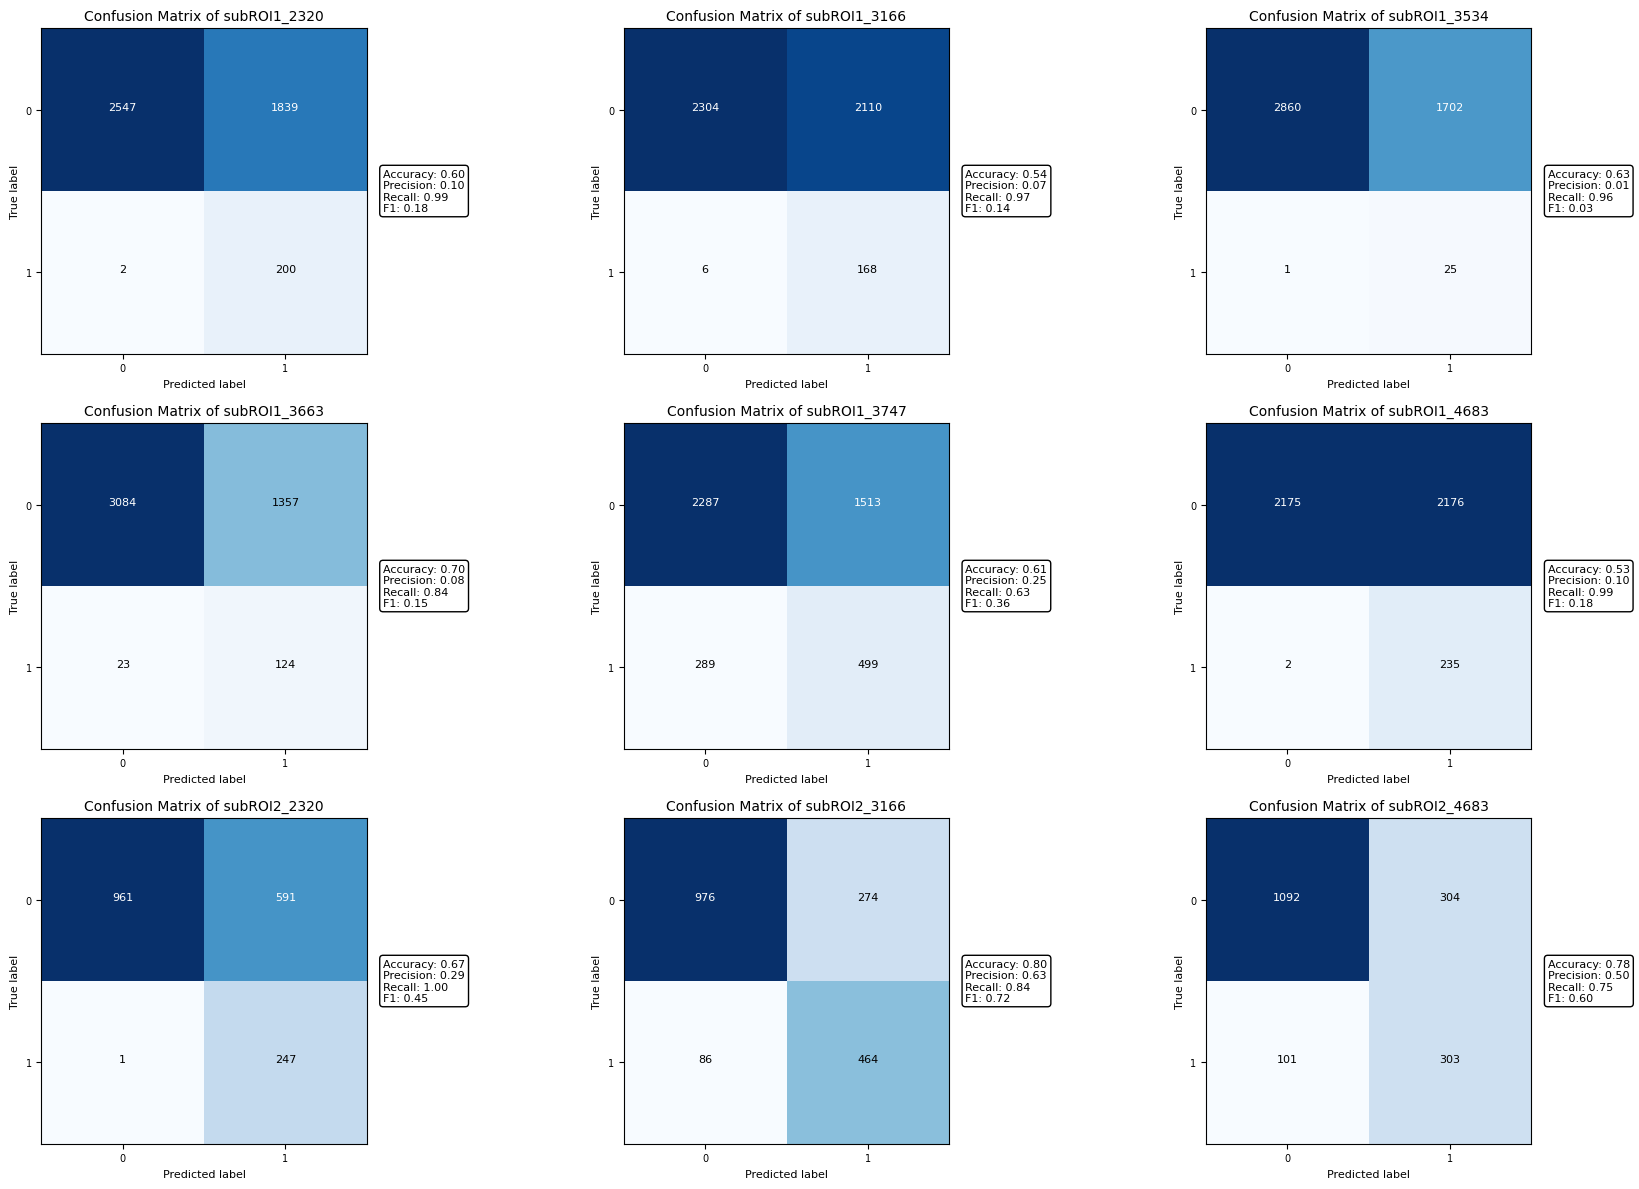

In [2]:
# Statistical indicators were calculated.
application_data_path = '/content/gdrive/MyDrive/irp_project_111/data/Application_Data/application_data.csv'
model_saved_path = "/content/gdrive/MyDrive/irp_project_111/saved_models/RandomForest/rf"

data = load_data(application_data_path)
check_missing_values(data)

unnecessary_cols_list = ['Lon', 'Lat', 'Mean_Rainfall', 'Median_Rainfall']
region_name_ls = ['subROI1', 'subROI2']
data = preprocess_application_data(data, unnecessary_cols_list, region_name_ls)

unique_flood_id = data['Flood_ID'].unique().tolist()
datasets = get_datasets_for_Modeling(data, drop_flood_id=True, drop_duplicates=False, print_discard_duplicates_info=False)

results = apply_model_and_evaluate(datasets, model_saved_path, unique_flood_id, save_path="/content/gdrive/MyDrive/irp_project_111/results/application/each_flood_cm.png")

### For Objective 2:  Applying the saved RandomForestClassifier model and generating flood maps

In [3]:
# reload data:
application_data_path = '/content/gdrive/MyDrive/irp_project_111/data/Application_Data/application_data.csv'
data = load_data(application_data_path)

# get the coors df:
sub_roi1_coors_df = get_coors_df(data,'subROI1_2320')
sub_roi2_coors_df = get_coors_df(data,'subROI2_2320')

# get each flood event actual labels:
all_actual_labels_dic = get_actual_labels(data)

# get each flood event model predicted results:
all_predicted_binary_results_dic = {}
all_predicted_proba_results_dic = {}
unique_flood_id = data['Flood_ID'].unique().tolist()

# reload model:
model = RandomForestClassifier()
model_saved_path = "/content/gdrive/MyDrive/irp_project_111/saved_models/RandomForest/rf"

# Start applying the model:
for i, data in enumerate(datasets):
    loaded_model = load(f"{model_saved_path}_iter_{i+1}.joblib")
    # drop label
    application_data = data.drop(columns=["label"])
    # check feature order from saved model
    feature_order = loaded_model.feature_names_in_
    # apply that order to our data
    application_data_reordered = application_data[feature_order]
    # start predict binary results:
    predictions = loaded_model.predict(application_data_reordered)
    predictions_ls = predictions.tolist()
    all_predicted_binary_results_dic[unique_flood_id[i]] = predictions_ls

    # start predict proba results:
    proba = loaded_model.predict_proba(application_data_reordered)[:, 1] # Probability that flooding will occur
    proba_ls = proba.tolist()
    all_predicted_proba_results_dic[unique_flood_id[i]] = proba_ls

# Example of ploting a flood map:
# if you wish to plot the actual flood map, then please use 'all_actual_labels_dic' as 1st input to plot_flood_maps_corrected fuc:
actual_flood_maps = plot_flood_maps_corrected(all_actual_labels_dic, sub_roi1_coors_df, sub_roi2_coors_df, predict_or_actual="actual" ,save_path='/content/gdrive/MyDrive/irp_project_111/results/application/flood_map/')

# if you wish to plot the predicted binary flood map, then please use 'all_predicted_binary_results_dic' as 1st input to plot_flood_maps_corrected fuc:
predicted_binary_flood_maps = plot_flood_maps_corrected(all_predicted_binary_results_dic, sub_roi1_coors_df, sub_roi2_coors_df, predict_or_actual="predicted_binary" ,save_path='/content/gdrive/MyDrive/irp_project_111/results/application/flood_map/')

# if you wish to plot the predicted probability flood map, then please use 'all_predicted_proba_results_dic' as 1st input to plot_flood_maps_corrected fuc:
predicted_probability_flood_maps = plot_flood_maps_corrected(all_predicted_proba_results_dic, sub_roi1_coors_df, sub_roi2_coors_df, predict_or_actual="predicted_prob" ,save_path='/content/gdrive/MyDrive/irp_project_111/results/application/flood_map/')

In [4]:
# Example of showing a predicted probability flood map(for last event):
# More maps can be checked and view directly in folder: /results/application/flood_map
predicted_probability_flood_maps[8] # free to change the index here to by view different maps.

# Example of view predicted binary maps (the last event):
# predicted_binary_flood_maps[8]

# Example of view actual binary maps (the last event):
# actual_flood_maps[8]